In [1]:
import tensorflow as tf

import time

import numpy as np
import matplotlib.pyplot as plt

from solver import Solver, LRSchedule
from pyDOE import lhs

In [2]:
nb_col = 10000
nb_bound = 150
nb_train_col = 9000
nb_train_bound = 130

# data
boundary_t0 = np.concatenate([np.zeros([nb_bound//2, 1]), 
                              lhs(1, samples = nb_bound // 2)*2. - 1], axis=1)
boundary_xm1 = np.concatenate([lhs(1, samples = nb_bound // 4), 
                               -np.ones([nb_bound//4, 1])], axis=1)
boundary_x1 = np.concatenate([lhs(1, samples = nb_bound // 4),
                              np.ones([nb_bound//4, 1])], axis=1)
boundary = np.concatenate([boundary_t0, boundary_xm1, boundary_x1], axis=0)

boundary_cond_t0 = - np.sin(np.pi*boundary_t0[:, 1])
boundary_cond_xm1 = np.zeros_like(boundary_xm1[:, 1])
boundary_cond_x1 = np.zeros_like(boundary_x1[:, 1])
boundary_cond = np.concatenate([boundary_cond_t0, 
                                boundary_cond_xm1, 
                                boundary_cond_x1], axis=0).flatten()

collocation = lhs(2, samples=nb_col)
collocation[:, 1] = collocation[:, 1]*2 - 1

perm_col = np.random.permutation(len(collocation))
perm_bound = np.random.permutation(len(boundary_cond))
boundary, collocation = boundary[perm_bound, :], collocation[perm_col, :]
boundary_cond = boundary_cond[perm_bound].reshape(-1, 1)

# test and train data
boundary_train = tf.Variable(boundary[:nb_train_bound, :], dtype=tf.float32)
collocation_train = tf.Variable(collocation[:nb_train_col, :], dtype=tf.float32)
boundary_cond_train = tf.Variable(boundary_cond[:nb_train_bound, :], dtype=tf.float32)

boundary_test = tf.Variable(boundary[nb_train_bound:, :], dtype=tf.float32)
collocation_test = tf.Variable(collocation[nb_train_col:, :], dtype=tf.float32)
boundary_cond_test = tf.Variable(boundary_cond[nb_train_bound:, :], dtype=tf.float32)

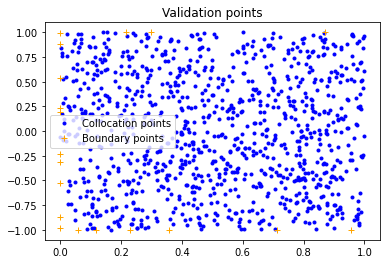

In [3]:
plt.title('Validation points')
plt.plot(collocation_test[:,0], collocation_test[:, 1], '.', color='blue', label='Collocation points')
plt.plot(boundary_test[:,0], boundary_test[:, 1], '+', color='orange', label='Boundary points')
plt.legend();

In [4]:
def burger_fun(v_fun, t, x, training=False):
  with tf.GradientTape(persistent=True) as g2:
    g2.watch(x), g2.watch(t)
    with tf.GradientTape(persistent=True) as g1:
      g1.watch(x), g1.watch(t)
      v = v_fun(t, x, training=training)
    v_t = g1.gradient(v, t)
    v_x = g1.gradient(v, x)
  v_xx = g2.gradient(v_x, x)

  return v_t + v*v_x - (0.01/np.pi)*v_xx

In [11]:
monitor = LRSchedule(decay_factor=0.5, patience=50, restore_best=True)
solver = Solver(collocation_test, boundary_test, boundary_cond_test, burger_fun, lr_sch=monitor, dropout=0, lr=0.01)

solver.train(2000, collocation_train, boundary_train, boundary_cond_train, verbose=True)

2000 --- train_loss : 0.23514601588249207 --- val_loss : 0.18527431786060333 -- lr : 0.1
epoch 234/2000 --- train_loss : 0.22013919055461884 --- val_loss : 0.1776626855134964 -- lr : 0.1
epoch 235/2000 --- train_loss : 0.2115902304649353 --- val_loss : 0.15631070733070374 -- lr : 0.1
epoch 236/2000 --- train_loss : 0.18316248059272766 --- val_loss : 0.2036825269460678 -- lr : 0.1
epoch 237/2000 --- train_loss : 0.227858304977417 --- val_loss : 0.47821173071861267 -- lr : 0.1
epoch 238/2000 --- train_loss : 0.5267793536186218 --- val_loss : 0.276529461145401 -- lr : 0.1
epoch 239/2000 --- train_loss : 0.3098682761192322 --- val_loss : 0.2172713577747345 -- lr : 0.1
epoch 240/2000 --- train_loss : 0.24332375824451447 --- val_loss : 0.42512065172195435 -- lr : 0.1
epoch 241/2000 --- train_loss : 0.45074766874313354 --- val_loss : 0.2580605447292328 -- lr : 0.1
epoch 242/2000 --- train_loss : 0.2859915494918823 --- val_loss : 0.2110288441181183 -- lr : 0.1
epoch 243/2000 --- train_loss : 0

KeyboardInterrupt: 

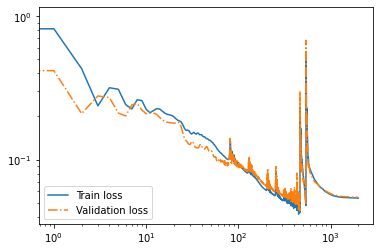

In [7]:
plt.loglog(solver.train_history, label='Train loss')
plt.loglog(solver.val_history, '-.', label='Validation loss')
plt.legend();

In [8]:
nu = 0.01/np.pi
import scipy.integrate as integrate 

def f(y):
  return np.exp(-np.cos(np.pi*y)/2/np.pi/nu)

def J1(s, t, x):
  return np.sin(np.pi*(x-s))*f(x-s)*np.exp(-s**2/4/nu/t)

def J2(s, t, x):
  return f(x-s)*np.exp(-s**2/4/nu/t)

def solution(t, x):
  I1 = integrate.quad(lambda s:J1(s, t, x), -1, 1)[0]
  I2 = integrate.quad(lambda s:J2(s, t, x), -1, 1)[0]
  return -I1/I2
  

<ipython-input-8-92fb02789e75>:14: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I1 = integrate.quad(lambda s:J1(s, t, x), -1, 1)[0]


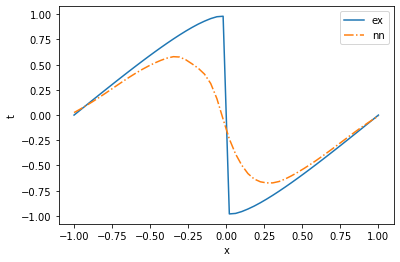

In [9]:
x = np.linspace(-1, 1, 50).reshape([-1, 1])
t = 0.5*np.ones_like(x)
v_ex = [solution(t, x) for (t,x) in zip(t.flatten(), x.flatten())]
v_neu = solver.v(t, x)
plt.plot(x, v_ex, label='ex')
plt.plot(x, v_neu, '-.', label='nn')
plt.xlabel("x")
plt.ylabel("t")
plt.legend();

<ipython-input-8-92fb02789e75>:14: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I1 = integrate.quad(lambda s:J1(s, t, x), -1, 1)[0]


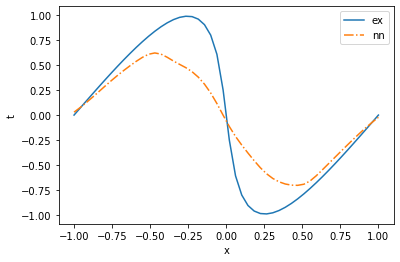

In [10]:
x = np.linspace(-1, 1, 50).reshape([-1, 1])
t = 0.25*np.ones_like(x)
v_ex = [solution(t, x) for (t,x) in zip(t.flatten(), x.flatten())]
v_neu = solver.v(t, x)
plt.plot(x, v_ex, label='ex')
plt.plot(x, v_neu, '-.', label='nn')
plt.xlabel("x")
plt.ylabel("t")
plt.legend();